In [145]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(font_scale=2, style='ticks')
from activity_swim_bout import *
from utils import cont_mode
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from utils import *
from scipy.signal import find_peaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

## Single neuron analysis

In [3]:
row = dat_xls_file.iloc[0]
folder = row['folder']
fish = row['fish']
print(f'Processing {folder} {fish}')
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
num_cell = spk.shape[0]
spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

Processing 03152018 Fish1-1


In [4]:
_ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

In [5]:
sub_list = np.zeros((r_swim.shape[0], subvolt.shape[0]))
remove_list = np.zeros(r_swim.shape[0]).astype('bool')
for n, n_swim in enumerate(swim_starts):
    try:
        sub_list[n, :] = subvolt[:, n_swim+50:n_swim+250].mean(axis=-1)
    except:
        remove_list[n]=True
task_period_ = task_period.copy()
task_period_[remove_list] = 0

In [6]:
sub_list_ = np.array(sub_list)
lda = LDA()
lda.fit(sub_list_[task_period_<3, :], task_period_[task_period_<3])
# sub_pc = svd.transform(subvolt.T)
# plt.plot(sub_list_.mean(axis=-1), task_period_, '.')

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [7]:
lda.score(sub_list_[task_period_<3, :], task_period_[task_period_<3])

0.588957055214724

## See if the high gain and low gain can be decoded using LDA coder

In [8]:
spk_list = np.zeros((r_swim.shape[0], spk.shape[0]))
remove_list = np.zeros(r_swim.shape[0]).astype('bool')
for n, n_swim in enumerate(swim_starts):
    try:
        spk_list[n, :] = spk[:, n_swim+0:n_swim+250].mean(axis=-1)*300
    except:
        remove_list[n]=True
task_period_ = task_period.copy()
task_period_[remove_list] = 0
spk_list_ = np.array(spk_list)
lda = LDA()
lda.fit(spk_list_[task_period_<3, :], task_period_[task_period_<3])
lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3])
coef_ = lda.coef_

In [52]:
k_ = boxcarKernel(600)
spk_smooth = spk.copy()
for ncell in range(spk_smooth.shape[0]):
    spk_smooth[ncell] = smooth(spk[ncell], k_)*300
pop_act = spk_smooth.T.dot(coef_.T)
pop_act = pop_act.ravel()

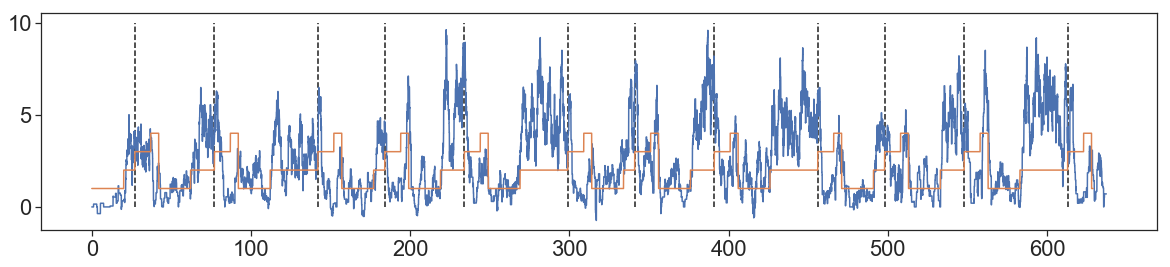

In [53]:
plt.figure(figsize=(20, 4))
plt.plot(np.arange(len(pop_act))/300, pop_act)
plt.plot(np.arange(len(frame_stimParams[2]))/300, frame_stimParams[2])

memory_on = np.where((frame_stimParams[2][:-1]==2) & (np.diff(frame_stimParams[2])==1))[0]
memory_task = frame_stimParams[3][memory_on]

plt.vlines([(np.arange(len(pop_act))/300)[memory_on]], 0, 10, linestyles='--')

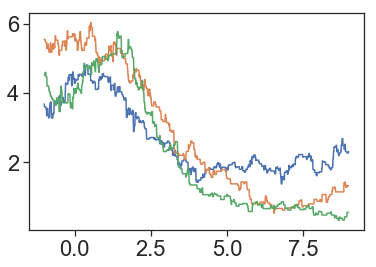

In [57]:
tmin = -1
tmax = 9

lda_mem = np.zeros((len(memory_on), (tmax-tmin)*300))
for n in range(len(memory_on)):
    lda_mem[n, :] = pop_act[memory_on[n]+tmin*300:memory_on[n]+tmax*300]

for n in range(1, 4):
    plt.plot(np.arange(tmin, tmax, 1/300), np.mean(lda_mem[memory_task==n], axis=0))

In [194]:
def memory_trace(row):
    folder = row['folder']
    fish = row['fish']
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    
    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    
    # remove low firing neurons
    low_fire = spk.mean(axis=-1)*300 < 0.2
    spk = spk[~low_fire, :]
    
    if spk.shape[0]<5:
        return None
    
    spk_list = np.zeros((r_swim.shape[0], spk.shape[0]))
    remove_list = np.zeros(r_swim.shape[0]).astype('bool')
    
    for n, n_swim in enumerate(swim_starts):
        try:
            spk_list[n, :] = spk[:, n_swim+0:n_swim+250].mean(axis=-1)*300
        except:
            remove_list[n]=True
    task_period_ = task_period.copy()
    task_period_[remove_list] = 0
    spk_list_ = np.array(spk_list)
    lda = LDA()
    lda.fit(spk_list_[task_period_<3, :], task_period_[task_period_<3])
    lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3])
    coef_ = lda.coef_
    
    if lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3])<0.7:
        return None
    
    print(f'Processing {folder} {fish}')
    print(lda.score(spk_list_[task_period_<3, :], task_period_[task_period_<3]))
    
    k_ = boxcarKernel(600)
    spk_smooth = spk.copy()
    for ncell in range(spk_smooth.shape[0]):
        spk_smooth[ncell] = smooth(spk[ncell], k_)*300
    pop_act = spk_smooth.T.dot(coef_.T)
    pop_act = pop_act.ravel()
    
    num_burst = np.zeros(r_swim.shape[0])
    int_burst = np.zeros(r_swim.shape[0])
    max_burst = np.zeros(r_swim.shape[0])
    ave_burst = np.zeros(r_swim.shape[0])
    fir_burst = np.zeros(r_swim.shape[0])

    for n_burst in range(r_swim.shape[0]):
        rswim = r_swim[n_burst, 50:200]
        lswim = l_swim[n_burst, 50:200]
        swim_ = np.sqrt(rswim**2+lswim**2)
        peaks_ = find_peaks(swim_, prominence=0.5)[0] 
        if len(peaks_) >1:
            num_burst[n_burst] = len(peaks_)/2
            int_burst[n_burst] = np.nanmean(np.diff(peaks_))
            max_burst[n_burst] = swim_.max()
            ave_burst[n_burst] = swim_[peaks_].mean()
            fir_burst[n_burst] = peaks_[0]

    burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
    burst_list = np.asarray(burst_list)
    
    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1
            
    tmin = -1
    tmax = 11
    memory_on = np.where((frame_stimParams[2][:-1]==2) & (frame_stimParams[2][1:]==3))[0]#np.where((frame_stimParams[2][:-1]==2) & (np.diff(frame_stimParams[2])==1))[0]
    memory_task = frame_stimParams[3][memory_on]
    lda_mem = np.zeros((len(memory_on), (tmax-tmin)*300))
    for n in range(len(memory_on)):
        lda_mem[n, :] = pop_act[memory_on[n]+tmin*300:memory_on[n]+tmax*300]
    
    
    swim_on_ind = (swim_bout_index_task== 1) & (task_period_==4)
    task_info = frame_stimParams[3][swim_starts][swim_on_ind].astype(int)
    valid_memory_trial = np.empty((len(memory_on)//3, 3))
    valid_memory_trial[:] = np.nan
    mm = int(0)
    for m, n__ in enumerate(task_info):
        valid_memory_trial[mm, n__-1] = burst_list[3][swim_on_ind][m]
        if m<len(task_info)-1 and n__>=task_info[m+1]:
            mm += 1
            
    valid_memory_trial = valid_memory_trial[:,0]>valid_memory_trial[:,2]
    if valid_memory_trial.sum() ==0:
        return None
    
    plt.plot(np.arange(tmin, tmax, 1/300), lda_mem[memory_task==1][valid_memory_trial].mean(axis=0), '-b')
    plt.plot(np.arange(tmin, tmax, 1/300), lda_mem[memory_task==3][valid_memory_trial].mean(axis=0), '-m')
    plt.xlim([-0.25, tmax-0.5])    
    plt.xlabel('Time from epoch onset')
    plt.ylabel('Neural act., coding direction')    
    plt.show()

    tmin = -1
    tmax = 7
        
    low_on = np.where((frame_stimParams[2][:-1]==4) & (frame_stimParams[2][1:]==1))[0]
    lda_low = np.zeros((len(low_on), (tmax-tmin)*300))
    for n in range(len(low_on)):
        lda_low[n, :] = pop_act[low_on[n]+tmin*300:low_on[n]+tmax*300]
    ave_ = np.mean(lda_low, axis=0)
    sem_ = np.std(lda_low, axis=0)/np.sqrt(len(low_on))
    plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-k', lw=2, label='low gain')
    plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--k', lw=0.5)
    plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--k', lw=0.5)
    
    high_on = np.where((frame_stimParams[2][:-1]==1) & (frame_stimParams[2][1:]==2))[0]
    lda_high = np.zeros((len(high_on), (tmax-tmin)*300))
    for n in range(len(low_on)):
        lda_high[n, :] = pop_act[high_on[n]+tmin*300:high_on[n]+tmax*300]
    ave_ = np.mean(lda_high, axis=0)
    sem_ = np.std(lda_high, axis=0)/np.sqrt(len(high_on))
    plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-r', lw=2, label='high gain')
    plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--r', lw=0.5)
    plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--r', lw=0.5)
    plt.xlim([-0.25, tmax-0.5])    
    plt.legend()
    plt.xlabel('Time from epoch onset')
    plt.ylabel('Neural act., coding direction')    
    plt.show()

Processing 03152018 Fish1-1
0.8282208588957055


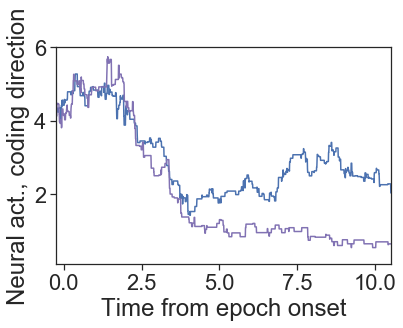

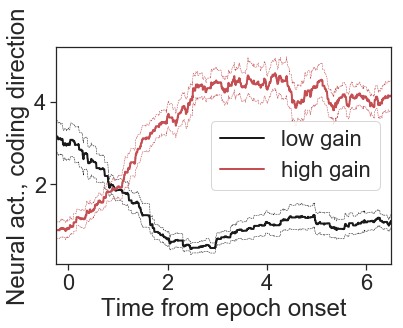

Processing 03152018 Fish4-1
0.8876651982378855


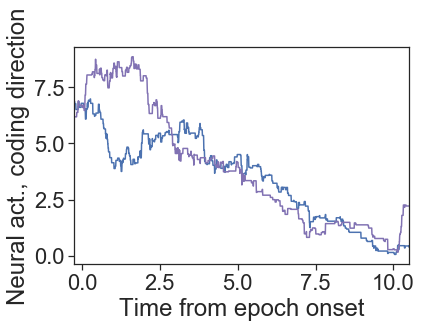

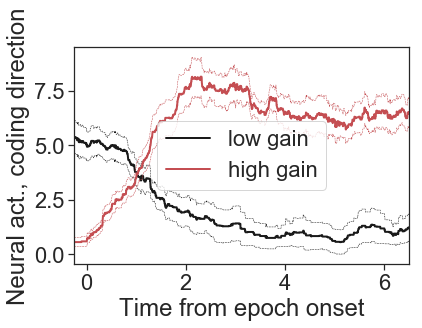

Processing 03152018 Fish4-2
0.75625


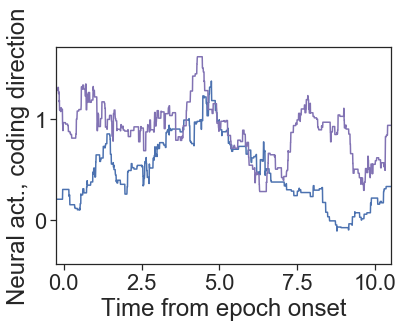

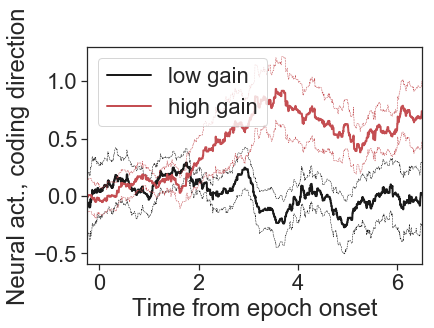

Processing 04052018 Fish4-1
0.7840531561461794


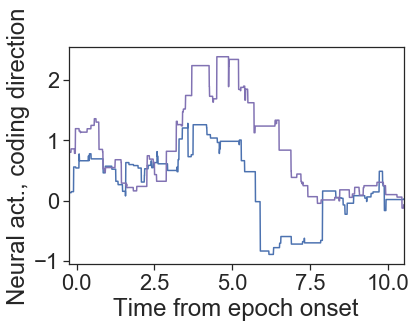

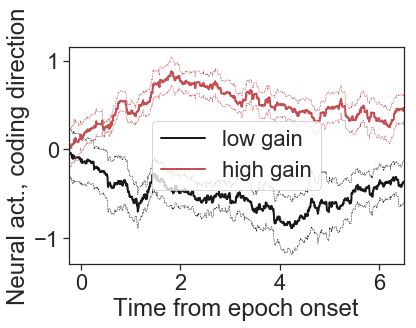

Processing 04052018 Fish4-2
0.7712418300653595


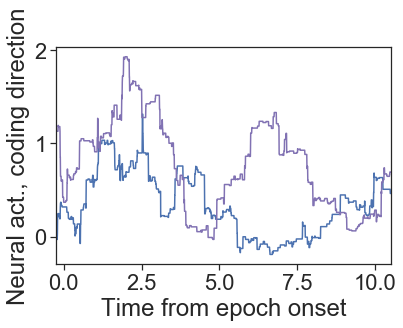

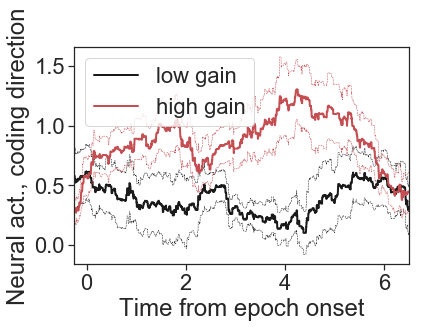

Processing 04122018 Fish2-1
0.8138686131386861


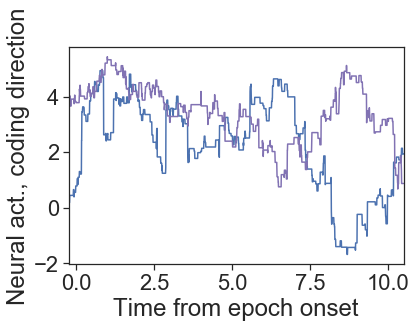

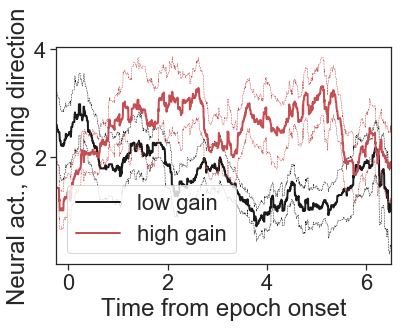

Processing 04122018 Fish2-2
0.8439716312056738


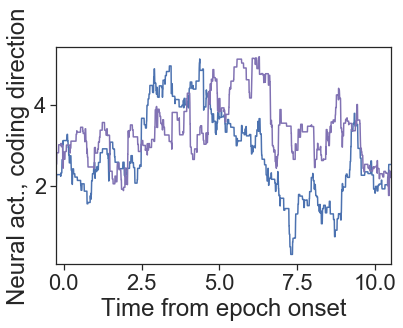

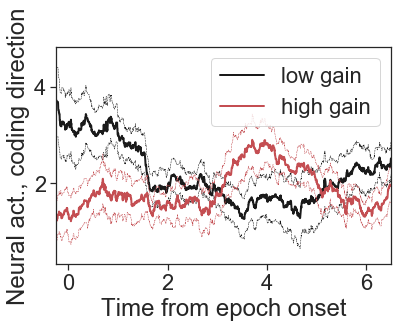

Processing 04192018 Fish1-1
0.7588652482269503


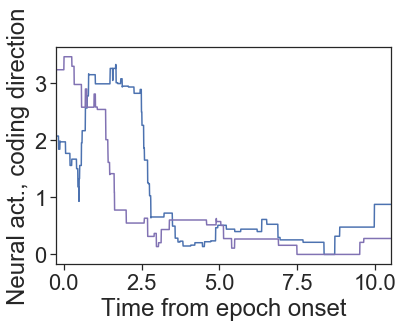

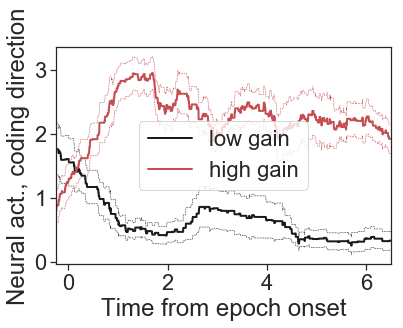

Processing 07122018 Fish1-1
0.7805825242718447
Processing 07122018 Fish2-2
0.7209876543209877


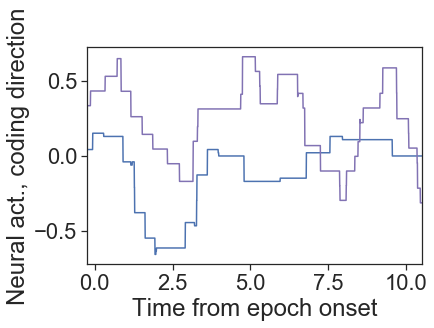

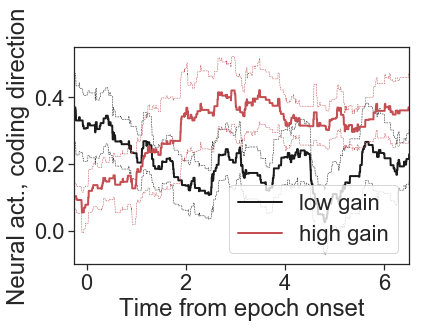

Processing 07262018 Fish2-1
0.7648305084745762


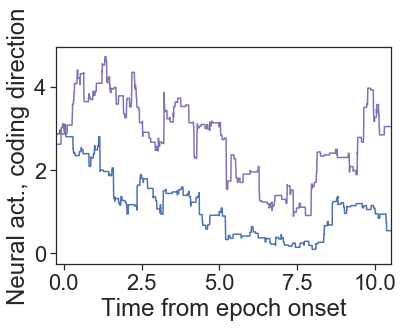

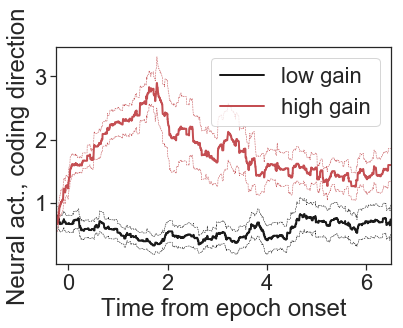

Processing 10182018 Fish2-1
0.7663551401869159


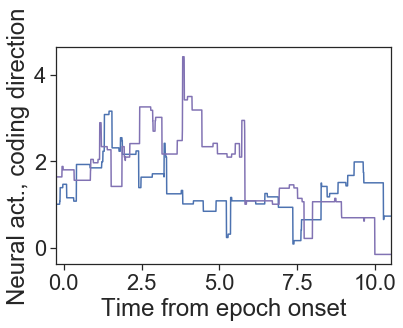

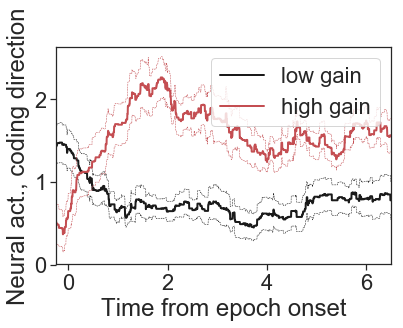

In [195]:
for _, row in dat_xls_file.iterrows():
    if 'memory' in row['task']:
        memory_trace(row)

## check if the fish has a memory

In [ ]:
from scipy.signal import find_peaks
num_burst = np.zeros(r_swim.shape[0])
int_burst = np.zeros(r_swim.shape[0])
max_burst = np.zeros(r_swim.shape[0])
ave_burst = np.zeros(r_swim.shape[0])
fir_burst = np.zeros(r_swim.shape[0])

for n_burst in range(r_swim.shape[0]):
    rswim = r_swim[n_burst, 50:200]
    lswim = l_swim[n_burst, 50:200]
    swim_ = np.sqrt(rswim**2+lswim**2)
    peaks_ = find_peaks(swim_, prominence=0.5)[0] 
#     peaks_rl = rswim[peaks]>lswim[peaks]
#     peaks_r = peaks[peaks_rl]
#     peaks_l = peaks[~peaks_rl]
#     if rswim.max()>lswim.max():
#         peaks_ = peaks_r
#         swim_ = rswim
#     else:
#         peaks_ = peaks_l
#         swim_ = lswim   
    if len(peaks_) >1:
        num_burst[n_burst] = len(peaks_)/2
        int_burst[n_burst] = np.nanmean(np.diff(peaks_))
        max_burst[n_burst] = swim_.max()
        ave_burst[n_burst] = swim_[peaks_].mean()
        fir_burst[n_burst] = peaks_[0]
    
burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
burst_list = np.asarray(burst_list)